# Model import using the Petab format

In this notebook, we illustrate using pyPESTO together with PEtab and AMICI. We employ models from the benchmark collection, which we first download:

In [1]:
import pypesto
import amici
import petab

import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Download benchmark models - Note: 200MB :(
!git clone --depth 1 https://github.com/LeonardSchmiester/Benchmark-Models.git tmp/benchmark-models || (cd tmp/benchmark-models && git pull)

fatal: destination path 'tmp/benchmark-models' already exists and is not an empty directory.
Already up to date.


## Manage PEtab model

A PEtab problem comprises all the information on the model, the data and the parameters to perform parameter estimation:

In [2]:
folder_base = "tmp/benchmark-models/hackathon_contributions_new_data_format/"
model_name = "Zheng_PNAS2012"
model_name = "Boehm_JProteomeRes2014"
yaml_config = os.path.join(folder_base, model_name, model_name + '.yaml')

petab_problem = petab.Problem.from_yaml(yaml_config)

# e.g.
petab_problem.get_optimization_to_simulation_parameter_mapping()

[({},
  {'Epo_degradation_BaF3': 'Epo_degradation_BaF3',
   'k_exp_hetero': 'k_exp_hetero',
   'k_exp_homo': 'k_exp_homo',
   'k_imp_hetero': 'k_imp_hetero',
   'k_imp_homo': 'k_imp_homo',
   'k_phos': 'k_phos',
   'ratio': 0.693,
   'specC17': 0.107,
   'noiseParameter1_rSTAT5A_rel': 'sd_rSTAT5A_rel',
   'noiseParameter1_pSTAT5A_rel': 'sd_pSTAT5A_rel',
   'noiseParameter1_pSTAT5B_rel': 'sd_pSTAT5B_rel'})]

## Import model to AMICI

The model must be imported to AMICI:

In [3]:
importer = pypesto.PetabImporter(petab_problem)

model = importer.create_model()

print("Model parameters:", list(model.getParameterIds()), '\n')
print("Model const parameters:", list(model.getFixedParameterIds()), '\n')
print("Model outputs:   ", list(model.getObservableIds()), '\n')
print("Model states:    ", list(model.getStateIds()), '\n')

2020-02-06 23:43:38.446 - amici.petab_import - INFO - Importing model ...
2020-02-06 23:43:38.448 - amici.petab_import - INFO - Model name is 'Boehm_JProteomeRes2014'. Writing model code to '/home/yannik/pypesto/doc/example/amici_models/Boehm_JProteomeRes2014'.
2020-02-06 23:43:38.449 - amici.petab_import - INFO - Species: 8
2020-02-06 23:43:38.450 - amici.petab_import - INFO - Global parameters: 9
2020-02-06 23:43:38.451 - amici.petab_import - INFO - Reactions: 9
2020-02-06 23:43:38.466 - amici.petab_import - INFO - Observables: 3
2020-02-06 23:43:38.472 - amici.petab_import - INFO - Sigmas: 3
2020-02-06 23:43:38.482 - amici.petab_import - DEBUG - Adding output parameters to model: {'noiseParameter1_rSTAT5A_rel', 'noiseParameter1_pSTAT5A_rel', 'noiseParameter1_pSTAT5B_rel'}
2020-02-06 23:43:38.484 - amici.petab_import - DEBUG - Condition table: (1, 1)
2020-02-06 23:43:38.487 - amici.petab_import - DEBUG - Fixed parameters are []
2020-02-06 23:43:38.491 - amici.petab_import - INFO - Ov

running build_ext
building 'Boehm_JProteomeRes2014._Boehm_JProteomeRes2014' extension
swigging swig/Boehm_JProteomeRes2014.i to swig/Boehm_JProteomeRes2014_wrap.cpp
swig -python -c++ -modern -outdir Boehm_JProteomeRes2014 -I/home/yannik/amici/python/sdist/amici/swig -I/home/yannik/amici/python/sdist/amici/include -o swig/Boehm_JProteomeRes2014_wrap.cpp swig/Boehm_JProteomeRes2014.i
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/swig
gcc -pthread -B /home/yannik/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -fPIC -I/home/yannik/pypesto/doc/example/amici_models/Boehm_JProteomeRes2014 -I/home/yannik/amici/python/sdist/amici/include -I/home/yannik/amici/python/sdist/amici/ThirdParty/gsl -I/home/yannik/amici/python/sdist/amici/ThirdParty/sundials/include -I/home/yannik/amici/python/sdist/amici/ThirdParty/SuiteSparse/include -I/usr/include/hdf5/serial -I/home/yannik/anaconda3/include/python3.7m -c swig/Boehm_J

## Create objective function

In [4]:
obj = importer.create_objective()

obj(petab_problem.x_nominal_scaled, sensi_orders=(0,1))

(138.22199669642814,
 array([ 2.20244501e-02,  5.53227488e-02,  5.78815970e-03,  5.38990426e-03,
        -4.51595806e-05,  7.91572700e-03,  0.00000000e+00,  1.07825579e-02,
         2.40394418e-02,  1.91922979e-02,  0.00000000e+00]))

## Run optimization

In [12]:
optimizer = pypesto.ScipyOptimizer()

problem = importer.create_problem(obj)

#engine = pypesto.SingleCoreEngine()
engine = pypesto.MultiProcessEngine()

# do the optimization
result = pypesto.minimize(problem=problem, optimizer=optimizer,
                          n_starts=10, engine=engine)

Engine set up to use up to 4 processes in total. The number was automatically determined and might not be appropriate on some systems.
[Warning] AMICI:mex:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 22.6917, mxstep steps taken before reaching tout. 
[Warning] AMICI:mex:simulation: AMICI forward simulation failed at t = 22.691660:
AMICI failed to integrate the forward problem

[Warning] AMICI:mex:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 89.1487 and h = 6.71703e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:mex:simulation: AMICI forward simulation failed at t = 89.148669:
AMICI failed to integrate the forward problem

[Warning] AMICI:mex:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 89.1487 and h = 6.71703e-06, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:mex:simulation: AMICI forward simulation failed at t = 89.14866

## Visualize

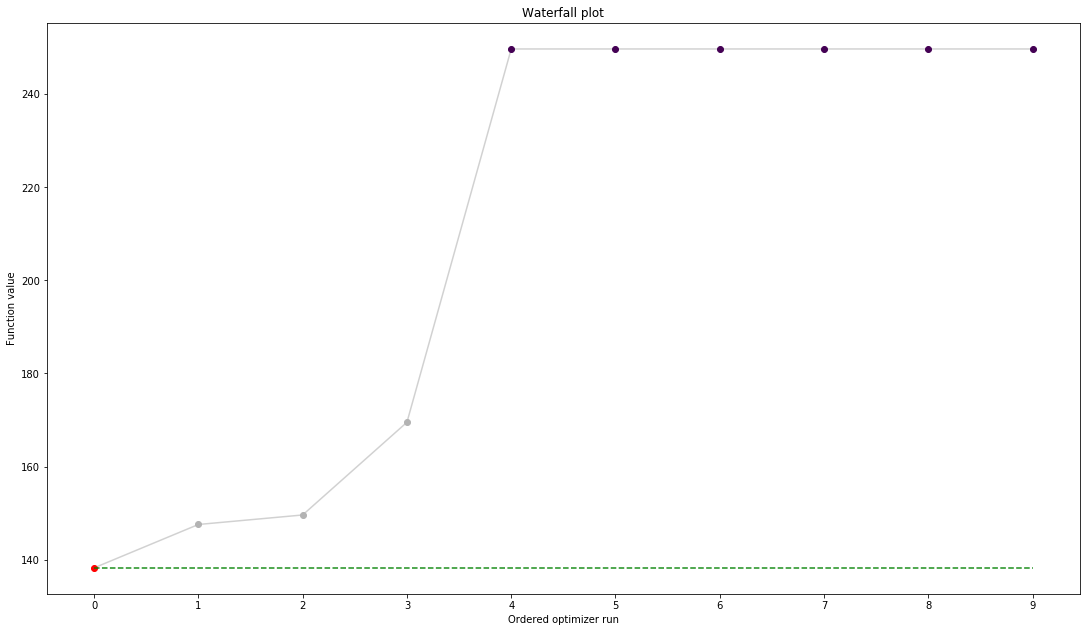

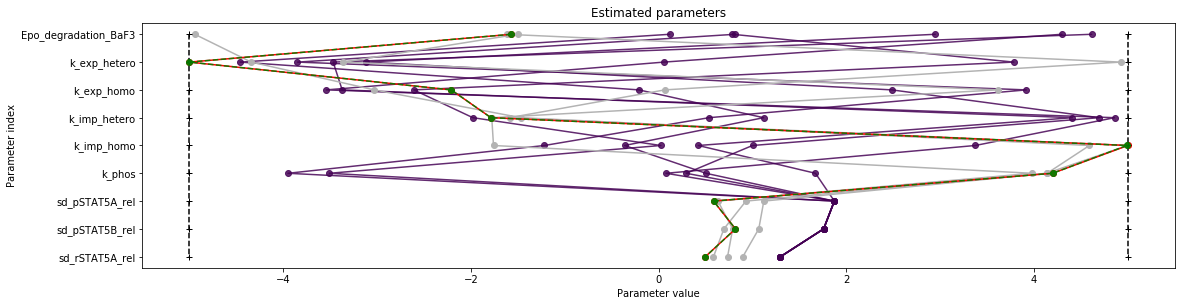

In [14]:
import pypesto.visualize

ref = pypesto.visualize.create_references(x=petab_problem.x_nominal_scaled, fval=obj(petab_problem.x_nominal_scaled))

pypesto.visualize.waterfall(result, reference=ref, scale_y='lin')
pypesto.visualize.parameters(result, reference=ref)